In [88]:
from typing import List
import pandas as pd
import numpy as np
import math
import pdb
import plotly.express as exp

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score

In [77]:
class NeuralNetwork():
    def __init__(self, X, Y, layers: List[int], learning_rate = 0.01, num_itr: int = 500):
        """
        layers: include input and output layers
        """
        self.m = X.shape[1]
        self.X = X
        self.Y = Y
        self.learning_rate = learning_rate
        self.num_itr = num_itr
        self.W_cache = {}
        self.b_cache = {}
        self.Z_cache = {}
        self.A_cache = {}
        self.dZ_cache = {}
        self.num_layers = len(layers)
        assert self.num_layers >= 3, f'layers must greater than or equal to 3, Including the input" \
            "and output layers'

        for l in range(self.num_layers - 1):
            self.W_cache[f'W{l + 1}'] = np.random.rand(layers[l + 1], layers[l])
            self.b_cache[f'b{l + 1}'] = np.random.rand(layers[l + 1], 1)

    def fit(self):
        self.A_cache[f'A0'] = self.X
        for i in range(self.num_itr):
            A = self.forward_prop()

            J = self.cost_function(self.Y, A)
            if i % 50 == 49:
                print(f'cost: {J}')
            
            self.backward_prop()
        return self

    def predict(self, X):
        return self.forward_prop(X)

    def cost_function(self, Y, A):
        _, m = Y.shape

        # print(f'm: {m}')
        J = - 1 / m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
        # print(f'J: {J}')
        # if J
        return J

    def forward_prop_one_layer(self, X, W, b, l, activation='sigmoid'):
        """
        W, n_l+1, n_
        """
        Z = np.dot(W, X) + b

        if activation == 'sigmoid':
            A = 1 / (1 + np.exp(-Z))
        elif activation == 'tanh':
            A = np.tanh(Z)
        else:
            raise ValueError(f'Invalid activation: {activation}')

        self.Z_cache[f'Z{l}'] = Z
        self.A_cache[f'A{l}'] = A
        return A
            
    def forward_prop(self, X = None):
        if X is not None:
            A = X
        else:
            A = self.A_cache['A0']
        
        for l in range(self.num_layers - 1):
            W = self.W_cache[f'W{l + 1}']
            b = self.b_cache[f'b{l + 1}']

            if l + 1 == self.num_layers - 1: # if last layer
                A = self.forward_prop_one_layer(A, W, b, l+1)
            else:
                A = self.forward_prop_one_layer(A, W, b, l+1, 'tanh')

        return A

    def backward_prop_one_layer(self, l):
        """
        update W, b for layer i
        """
        # print(f'back prop: {l}')
        A = self.A_cache[f'A{l}']
        A_prev = self.A_cache[f'A{l - 1}']
        # print(f'A_prev shape: {A_prev.shape}, A shape: {A.shape}')
        if l == self.num_layers - 1:
            # print(f'Y.shape: {self.Y.shape}')
            dZ = A - self.Y
            dW = 1/self.m * np.dot(A - self.Y, A_prev.transpose())
            db = 1/self.m * np.sum(A - self.Y, axis=1, keepdims=True)
        else:
            W_next = self.W_cache[f'W{l + 1}']
            dZ_next = self.dZ_cache[f'dZ{l + 1}']
            Z = self.Z_cache[f'Z{l}']
            dZ = np.dot(W_next.transpose(), dZ_next) * (1 - np.power(A, 2))
            dW = 1/self.m * np.dot(dZ, A_prev.transpose())
            db = 1/self.m * np.sum(dZ, axis=1, keepdims=True)

        self.dZ_cache[f'dZ{l}'] = dZ
        
        self.W_cache[f'W{l}'] = self.W_cache[f'W{l}'] - self.learning_rate * dW
        self.b_cache[f'b{l}'] = self.b_cache[f'b{l}'] - self.learning_rate * db
        # pdb.set_trace()
            
    def backward_prop(self):
        for l in range(self.num_layers - 1):
            self.backward_prop_one_layer(self.num_layers - 1 - l)
            

In [4]:
df = pd.read_csv('/Users/danielkuo/Desktop/heart_disease_prediction/framingham.csv')
columns_with_na = df.isna().sum(axis=0) > 0
X = df.loc[:, (~df.columns.isin(['TenYearCHD'])) & (~columns_with_na)].to_numpy()
Y = df['TenYearCHD'].to_numpy().reshape(-1, 1)

In [157]:
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [5]:
df['TenYearCHD'].value_counts()

TenYearCHD
0    3594
1     644
Name: count, dtype: int64

In [6]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X)
scaled_X = min_max_scaler.transform(X)

In [7]:
_, m = scaled_X.shape

In [8]:
m

8

In [144]:
nn = NeuralNetwork(scaled_X.transpose(), Y.transpose(), [m, 4, 1], num_itr=600, learning_rate=0.01)

In [145]:
nn.fit()

cost: 1.0018940904244267
cost: 0.652525046010737
cost: 0.5263657663548229
cost: 0.47726916854153995
cost: 0.45598045016529254
cost: 0.4459141461080566
cost: 0.4408301948188337
cost: 0.43812055743173656
cost: 0.4366021817874201
cost: 0.43570455474422876
cost: 0.4351397804221335
cost: 0.4347575953234992


In [146]:
a = nn.predict(scaled_X.transpose())

In [147]:
fpr, tpr, thresholds = roc_curve(Y.reshape(-1), a.reshape(-1))

In [148]:
df_roc = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

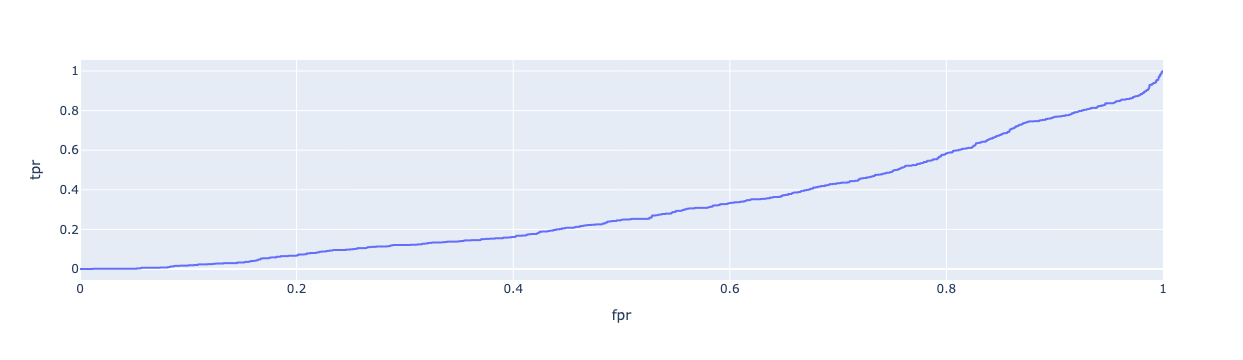

In [149]:
exp.line(df_roc, x= 'fpr', y='tpr', hover_data='thresholds')

In [153]:
cmd = ConfusionMatrixDisplay(confusion_matrix(Y.reshape(-1), a.reshape(-1) >= 0.197))

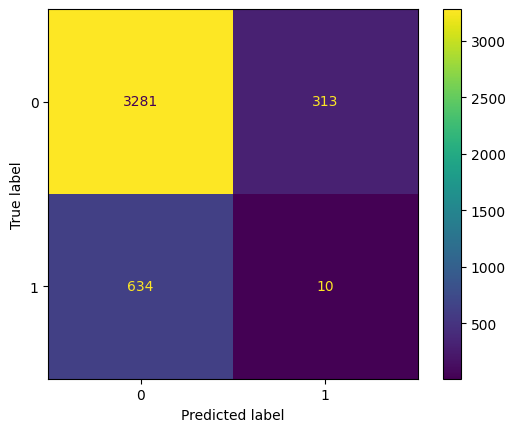

In [154]:
cmd.plot()